In this project we are going to explore the machine learning workflow. Specifically, we'll be looking at the famous titanic dataset. This project is an extended version of a guided project from dataquest, you can check them out [here](https://dataquest.io).

The goal of this project is to accurately predict if a passenger survived the sinking of the Titanic or not. We must predict a 0 or 1 value for the 'Survived' column in the test dataset. Then we'll submit the file of the predictions to kaggle.

For more information on this competition, click [here](https://www.kaggle.com/c/titanic).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline

train = pd.read_csv('train.csv')
holdout = pd.read_csv('test.csv')

### Data Exploration

---

Before we modify the dataframe and generate new columns, the first step is to plan out what needs to be done. We can explore the data with the basic pandas functions. In addition, we'll refer to the data information given by kaggle.

In [2]:
holdout.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [3]:
holdout.dtypes

PassengerId      int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

Here are some of my initial findings:

+ PassengerID is a numerical column with an identification number not useful for machine learning. 
+ Pclass is a numerical column with three values: 1, 2, and 3.
+ Name is a text column that includes the titles of the passengers. This is going to be useful in determining the social status of the passengers.
+ Sex is a text column with two values: male, and female.
+ Age is a numerical column, but can be converted into age categories.
+ SibSp is a numerical column showing the number of siblings/spouses aboard the Titanic.	
+ Parch is a numerical column showing the number of parents/children aboard the Titanic. 		
+ Ticket is a text column, but it is just the serial number not useful for machine learning.
+ Fare is a numerical column, but can be converted into price categories.
+ Cabin is text column with cabin numbers.
+ Embarked is a text column with information of the boarding location: C = Cherbourg, Q = Queenstown, S = Southampton.

Additional exploration will be required for most of these columns, but we can safely drop 'PassengerID' and 'Ticket'.

#### Pclass

This is a categorical column with 3 values. We'll want to create 3 dummy columns with binary values(0 and 1) for this variable. I'll demonstrate this later in the feature engineering section.

First, let's take a look at this column relative to the 'Survived' column


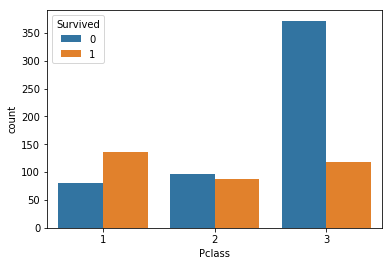

In [4]:
sns.countplot(train['Pclass'], hue=train['Survived'])
plt.show()

In [5]:
print('correlation = ' + str(train.corr()['Survived']['Pclass']))
train['Survived'].groupby(train['Pclass']).mean()

correlation = -0.338481035961


Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64

We are seeing a negative correlation for 'Pclass' and 'Survived'. Passengers with Pclass = 3 have a much lower survival rate than passengers with Pclass = 1.

#### Name

This is a text column containing information on the passenger's title. We'll want to split the title out of the string and create categorical columns.

In [6]:
train['Name'].head(5)

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

The structure for each string is { LAST NAME }, { TITLE } { FIRST NAME } { MIDDLE NAME }. 

We can split each split by the comma and select the title.

In [7]:
titles = train['Name'].apply(lambda x: x.split(', ')[1]).apply(lambda x: x.split(' ')[0])
train['Survived'].groupby(titles).mean().sort_values()

Name
Capt.        0.000000
Don.         0.000000
Jonkheer.    0.000000
Rev.         0.000000
Mr.          0.156673
Dr.          0.428571
Col.         0.500000
Major.       0.500000
Master.      0.575000
Miss.        0.697802
Mrs.         0.792000
Mme.         1.000000
Sir.         1.000000
Ms.          1.000000
Lady.        1.000000
Mlle.        1.000000
the          1.000000
Name: Survived, dtype: float64

This is interesting, the survival rate for passengers with the title 'Mr' is 0.157. The survival rate for passengers with the title 'Mrs.' is 0.792. There are way too many categories for this column, we'll have condense these titles down into a few categories later.

#### Sex

This is another categorical column with two possible values. My plan is to transform this column to a numerical column to a binary value, 0 for male, and 1 for female.

Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64


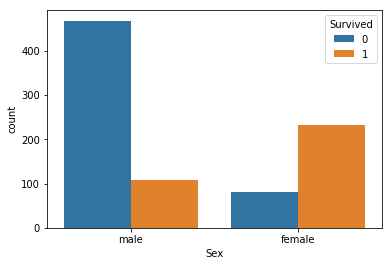

In [8]:
print(train['Survived'].groupby(train['Sex']).mean())

sns.countplot(train['Sex'], hue=train['Survived'])
plt.show()

This is very closely tied with the 'Mr' and 'Mrs' titles I talked about earlier. Women had a much higher chance of survival on the titanic.

#### Age

For this column, it is better to split the data into age categories.

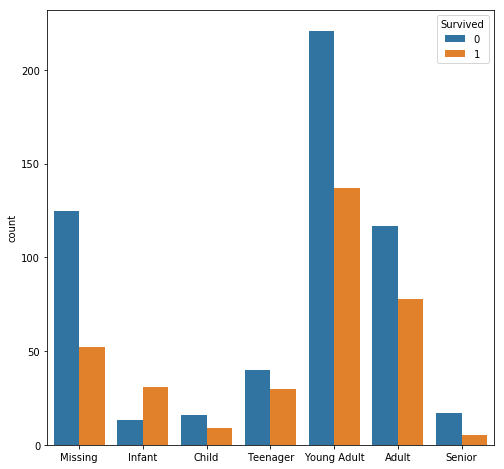

Age
Senior         0.227273
Missing        0.293785
Child          0.360000
Young Adult    0.382682
Adult          0.400000
Teenager       0.428571
Infant         0.704545
Name: Survived, dtype: float64


In [9]:
Ages = train["Age"].fillna(-0.5)
cut_points = [-1,0,5,12,18,35,60,100]
label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
Ages_category = pd.cut(Ages,cut_points,labels=label_names)

fig = plt.figure(figsize=(8, 8))
sns.countplot(Ages_category, hue=train['Survived'])
plt.xlabel('')
plt.show()
print(train['Survived'].groupby(Ages_category).mean().sort_values())

It looks like infants(age 0-5) have the highest rate of survival.

#### SibSp and Parch

These two columns are quite interesting, because it has to do with the number of family members the passengers have.

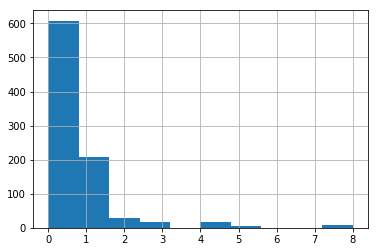

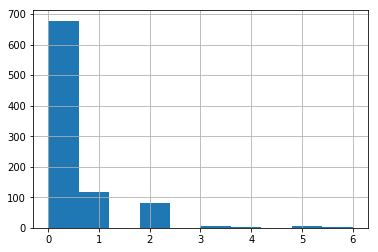

In [10]:
train['SibSp'].hist()
plt.show()
train['Parch'].hist()
plt.show()

In [11]:
pd.pivot_table(train, values='Survived', index=['SibSp'], aggfunc=np.mean)

,Survived
SibSp,
0,0.345395
1,0.535885
2,0.464286
3,0.250000
4,0.166667
5,0.000000
8,0.000000


In [12]:
pd.pivot_table(train, values='Survived', index=['Parch'], aggfunc=np.mean)

,Survived
Parch,
0,0.343658
1,0.550847
2,0.500000
3,0.600000
4,0.000000
5,0.200000
6,0.000000


The majority of the data of the 'Parch' and 'SibSp' column have values of 0 and 1, so we'll focus on those values. We are seeing a positive correlation for both of these columns.

We can see passengers with 0 'SibSp' or 0 'Parch' have a much lower rate of survival. It might be a good idea to combine these two columns.

#### Fare

Passengers with a higher social standing can afford to pay for a higher passenger class. So this column relates back to the 'Name' column and the 'Pclass' column.

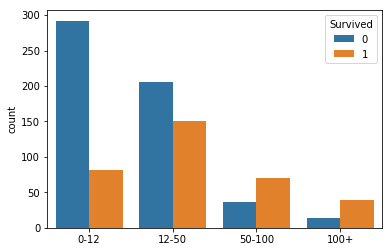

Fare
0-12      0.219251
12-50     0.422969
50-100    0.654206
100+      0.735849
Name: Survived, dtype: float64


In [13]:
cut_points = [-1,12,50,100,1000]
label_names = ["0-12","12-50","50-100","100+"]
Fare_categories = pd.cut(train["Fare"],cut_points,labels=label_names)

sns.countplot(Fare_categories, hue=train['Survived'])
plt.xlabel('')
plt.show()
print(train['Survived'].groupby(Fare_categories).mean().sort_values())

As expected, passengers with more expensive fares have a higher rate of survival. There are a few missing values in this column, so we'll use the mean to fill them out.

#### Cabin

The cabin column contains a letter followed by some numbers. The plan is to split this column into categories containing only the first letter.

In [14]:
cabin_letters = train['Cabin'].str[0]
cabin_letters = cabin_letters.fillna('Unknown')
cabin_letters.value_counts()
print(train['Survived'].groupby(cabin_letters).mean().sort_values())

Cabin
T          0.000000
Unknown    0.299854
A          0.466667
G          0.500000
C          0.593220
F          0.615385
B          0.744681
E          0.750000
D          0.757576
Name: Survived, dtype: float64


We can see that passengers with cabin have a higher chance of survival. However, the majority of the passengers did not have a cabin. 

#### Embarked

This column has three categories. Each category is a city name where the passenger boarded.

In [15]:
train['Survived'].groupby(train['Embarked']).mean().sort_values()

Embarked
S    0.336957
Q    0.389610
C    0.553571
Name: Survived, dtype: float64

We see that passengers from Cherbourg had a higher rate of survival. 

In [16]:
train[train['Embarked'] == 'C']['Pclass'].value_counts()

1    85
3    66
2    17
Name: Pclass, dtype: int64

This column is closely related to Pclass as well. The majority of passengers from Cherbourg were in the first class. As for the missing values, we'll fill this out with 'U' for unknown.

### Feature Engineering

---

Now we've looked at the data, let's create categorical columns for the columns we've explored. Following through with the plan I mentioned in the data exploration section, I've written a set of functions shown below.

In [17]:
#Fill out missing values in the dataset.
def process_missing(df):
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("U")
    return df

#Create a column for sex, 1 for female, 0 for male.
def process_sex(df):
    df['is_female'] = df['Sex'].apply(lambda x: 1 if x == 'female' else 0)
    return df

#Create a column for age categories.
def process_age(df):
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df


#Create a column for fare categories.
def process_fare(df):
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df


#Create a column for cabin letters.
def process_cabin(df):
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df


#Create a column for passenger titles.
def process_titles(df):
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

#Create dummy columns for categorical data.
def create_dummies(df,column_name):
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

In [18]:
def process_dataframe(df):
    df = process_missing(df)
    df = process_sex(df)
    df = process_age(df)
    df = process_fare(df)
    df = process_titles(df)
    df = process_cabin(df)
    
    cols = ["Pclass", "Title", "Age_categories", "Fare_categories", "Cabin_type", "Embarked"]
    for col in cols:
        df = create_dummies(df, col)
    return df

In [19]:
train = pd.read_csv('train.csv')
holdout = pd.read_csv('test.csv')

train = process_dataframe(train)
holdout = process_dataframe(holdout)

#### Revisiting SibSp and Parch

For the 'SibSp' and 'Parch' columns they are so closely related, I've decided to combine them in one column.

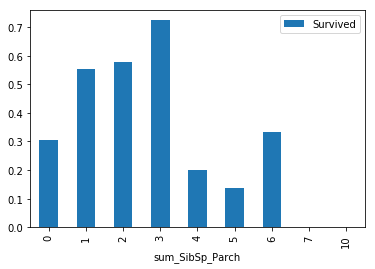

In [20]:
train['sum_SibSp_Parch'] = train['SibSp'] + train['Parch']
holdout['sum_SibSp_Parch'] = holdout['SibSp'] + holdout['Parch']

pivot_series = pd.pivot_table(train, values='Survived', index=['sum_SibSp_Parch'], aggfunc=np.mean)

pivot_series.plot.bar()
plt.show()

I took the sum of these two columns to see if we can see a positive correlation with the 'Survived' column, and this appears to be true. This makes sense because the sum of the two columns is just the family size. 

It is also very likely, that passengers who also had parents on board, have a higher survival rate because of their younger age.It is important to note that the data past x=3 is unreliable due to low sample size.

We can create a new column for passengers without a family.

In [21]:
def nofamily(df):
    if df['sum_SibSp_Parch'] == 0:
        return 1
    else:
        return 0

In [22]:
train['isalone'] = train.apply(nofamily, axis=1)
holdout['isalone'] = holdout.apply(nofamily, axis=1)

In [23]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Embarked', 'is_female', 'Age_categories',
       'Fare_categories', 'Title', 'Cabin_type', 'Pclass_1', 'Pclass_2',
       'Pclass_3', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs',
       'Title_Officer', 'Title_Royalty', 'Age_categories_Missing',
       'Age_categories_Infant', 'Age_categories_Child',
       'Age_categories_Teenager', 'Age_categories_Young Adult',
       'Age_categories_Adult', 'Age_categories_Senior', 'Fare_categories_0-12',
       'Fare_categories_12-50', 'Fare_categories_50-100',
       'Fare_categories_100+', 'Cabin_type_A', 'Cabin_type_B', 'Cabin_type_C',
       'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_F', 'Cabin_type_G',
       'Cabin_type_T', 'Cabin_type_Unknown', 'Embarked_C', 'Embarked_Q',
       'Embarked_S', 'Embarked_U', 'sum_SibSp_Parch', 'isalone'],
      dtype='object')

### Feature Selection 

---

For feature selection, let's try to use the RFECV function from scikit-learn. We'll optimize the features with respect to the random forest classifier model.

RFECV stands for **R**ecursive **F**eature **E**limination with **C**ross **V**alidation. This is an automated approach to help us select features that are relevant to the model. This is especially useful when we are dealing with a large number of columns. However, this is not the case for the titanic dataset. So it is important to keep in mind that we can still drop columns if our model is overfit.

In [24]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier

In [25]:
#Selects the optimal features for machine learning with RFECV
def select_features(df):
    
    #return a df with only numeric values
    numeric_df = df.select_dtypes(['float64', 'int64', 'uint8'])
    
    #drop columns with NA values and remove survived and passengerid
    selected_col = numeric_df.dropna(axis=1, how='any').columns.drop(['Survived', 'PassengerId'])
    all_X = df[selected_col]
    all_y = df['Survived']
    random_forest = RandomForestClassifier(random_state=1)
    selector = RFECV(random_forest, cv=10, step = 0.5)
    selector.fit(all_X, all_y)
    print(selected_col[selector.support_])
    return selected_col[selector.support_]

In [26]:
bf = select_features(train)

Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'is_female', 'Pclass_1',
       'Pclass_2', 'Pclass_3', 'Title_Master', 'Title_Miss', 'Title_Mr',
       'Title_Mrs', 'Title_Officer', 'Title_Royalty', 'Age_categories_Missing',
       'Age_categories_Infant', 'Age_categories_Child',
       'Age_categories_Teenager', 'Age_categories_Young Adult',
       'Age_categories_Adult', 'Age_categories_Senior', 'Fare_categories_0-12',
       'Fare_categories_12-50', 'Fare_categories_50-100',
       'Fare_categories_100+', 'Cabin_type_A', 'Cabin_type_B', 'Cabin_type_C',
       'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_F', 'Cabin_type_G',
       'Cabin_type_T', 'Cabin_type_Unknown', 'Embarked_C', 'Embarked_Q',
       'Embarked_S', 'Embarked_U', 'sum_SibSp_Parch', 'isalone'],
      dtype='object')


Even after applying the RFECV function from scikit-learn. We can still manually remove or add features using our domain knowledge.

'Cabin_T' and 'Embarked_U' were not generated in the holdout data set, so we should remove these columns.

In [27]:
bf = bf.drop(['Cabin_type_T', 'Embarked_U'])
bf

Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'is_female', 'Pclass_1',
       'Pclass_2', 'Pclass_3', 'Title_Master', 'Title_Miss', 'Title_Mr',
       'Title_Mrs', 'Title_Officer', 'Title_Royalty', 'Age_categories_Missing',
       'Age_categories_Infant', 'Age_categories_Child',
       'Age_categories_Teenager', 'Age_categories_Young Adult',
       'Age_categories_Adult', 'Age_categories_Senior', 'Fare_categories_0-12',
       'Fare_categories_12-50', 'Fare_categories_50-100',
       'Fare_categories_100+', 'Cabin_type_A', 'Cabin_type_B', 'Cabin_type_C',
       'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_F', 'Cabin_type_G',
       'Cabin_type_Unknown', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'sum_SibSp_Parch', 'isalone'],
      dtype='object')

### Model Selection and Hyperparameter Tuning

---

In [28]:
#Tunes the model to reduce error
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

def select_model(df, features):
    all_X = df[features]
    all_y = df['Survived']
        
    LogisticRegression_dict = {
        'model_name': 'LogisticRegression',
        'estimator': LogisticRegression(),
        'hyperparams': {
            "solver": ["newton-cg", "lbfgs", "liblinear"]
        }
    }
    
    KNeighborsClassifier_dict = {
        'model_name': 'KNeighborsClassifier',
        'estimator': KNeighborsClassifier(),
        'hyperparams': {   
            "n_neighbors": range(1,20,2),
            "weights": ["distance", "uniform"],
            "algorithm": ["ball_tree", "kd_tree", "brute"],
            "p": [1,2]
        }
    }
    
    RandomForestClassifier_dict = {
        'model_name': 'RandomForestClassifier',
        'estimator': RandomForestClassifier(),
        'hyperparams': {        
            "n_estimators": [4, 6, 9],
            "criterion": ["entropy", "gini"],
            "max_depth": [2, 5, 10],
            "max_features": ["log2", "sqrt"],
            "min_samples_leaf": [1, 5, 8],
            "min_samples_split": [2, 3, 5]
        }
    }
    hyper_params_list = [LogisticRegression_dict, KNeighborsClassifier_dict, RandomForestClassifier_dict]    
    scores = {}
    for model in hyper_params_list:
        print('-'*len(model['model_name']))
        print(model['model_name'])
        print('-'*len(model['model_name']))
        
        estimator = model['estimator']
        grid = GridSearchCV(estimator, model['hyperparams'], cv=10)
        grid.fit(all_X, all_y)
        model['best_params'] = grid.best_params_
        model['best_score'] = grid.best_score_ 
        model["best_model"] = grid.best_estimator_
        scores[model['model_name']] = grid.best_score_ 
        
        
        print('Best Score: ' + str(model['best_score']))
        print('Best Parameters: ' + str(model['best_params']))
    
    best_model = max(scores, key=scores.get)
    print('-'*len('Best Model: ' + str(best_model)))       
    print('Best Model: ' + str(best_model))
    print('-'*len('Best Model: ' + str(best_model)))   
    
    for model in hyper_params_list:
        if model['model_name'] == best_model:       
            print('Best Model Score: ' + str(model['best_score']))
            print('Best Model Parameters:' + str(model['best_params']))

    return hyper_params_list

params = select_model(train, bf)

------------------
LogisticRegression
------------------
Best Score: 0.82379349046
Best Parameters: {'solver': 'newton-cg'}
--------------------
KNeighborsClassifier
--------------------
Best Score: 0.775533108866
Best Parameters: {'weights': 'distance', 'n_neighbors': 17, 'p': 1, 'algorithm': 'brute'}
----------------------
RandomForestClassifier
----------------------
Best Score: 0.835016835017
Best Parameters: {'max_depth': 5, 'n_estimators': 4, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'entropy', 'max_features': 'sqrt'}
----------------------------------
Best Model: RandomForestClassifier
----------------------------------
Best Model Score: 0.835016835017
Best Model Parameters:{'max_depth': 5, 'n_estimators': 4, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'entropy', 'max_features': 'sqrt'}


Looks like our best model is the RandomForestClassifier. However, the score is purely based on the train dataset. It is possible that we are overfitting the data. 

I've only included a maximum of 9 trees in the grid search. If we include more trees in our forest, we should be able to reduce some overfitting.

### Applying the Machine Learning Model

---

In [29]:
def save_submission_file(col_list, filename="submission.csv"):
    
    #Training
    rf = RandomForestClassifier(
        min_samples_leaf=1, n_estimators=700, criterion='entropy', 
        max_depth= 10, max_features= 'sqrt', min_samples_split= 3)
    rf.fit(train[bf], train['Survived'])
    
    #Predict
    all_X = holdout[col_list]
    predictions = rf.predict(all_X)
    submission = pd.DataFrame({'PassengerId': holdout['PassengerId'], 'Survived': predictions})
    submission.to_csv(filename, index=False)

save_submission_file(bf)

That is it for now, this model had an accuracy score of 0.77990 on the holdout set. The accuracy score on the training set was 0.83501. This means that the model is still overfit.

We managed to hit the 50 percentile in the competition which is a great start.

---

#### Learning Summary

Concepts explored: feature engineering, feature selection, model selection, model tuning, binary classification problem

The files used for this project can be found in my [GitHub repository](https://github.com/sengkchu/codingdisciple.content/tree/master/Projects).
